In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit

from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, Lasso

## A. Dataset

Считываем данные и приводим колонку `'date'` к формату `datetime`.

In [2]:
df = pd.read_csv("energydata_complete.csv",  parse_dates=["date"])

Из `'date'` извлекаем `weekofyear` в колонку `'week'`.

In [3]:
df["week"] = df["date"].dt.isocalendar().week

Выбираем недели с 3 по 20.

In [4]:
df = df[(df["week"] > 2) & (df["week"] < 21)]

Делаем `'date'` индексом

In [5]:
df.set_index("date", inplace=True)

Преобразовываем данные к типу `float64`

In [6]:
df = df.astype("float64")

Отбираем данные за последнюю неделю

In [7]:
end_date = df.index.max()
start_date = end_date - pd.Timedelta(days=7)
last_week_df = df[(df.index >= start_date) & (df.index <= end_date)]

Строим график по данным за последнюю неделю

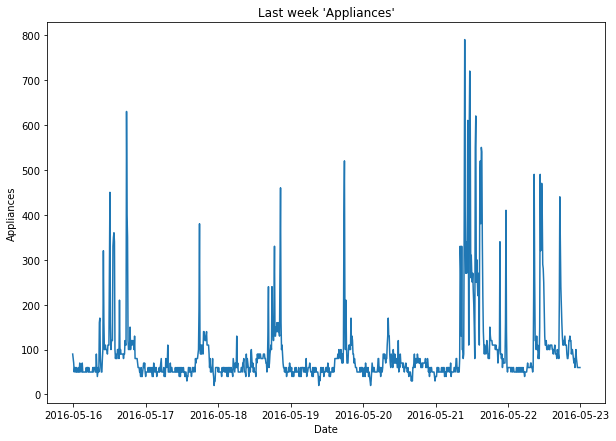

In [8]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(last_week_df["Appliances"])
plt.title("Last week 'Appliances'")
plt.xlabel("Date")
plt.ylabel("Appliances")
plt.show()

## B. Validation + C. Feature Extraction

**[?]** Валидация методом деления выборки на две части - тренировочную и тестовую называется **отложенной выборкой**

In [9]:
X = df.drop(columns=["Appliances"])
Y = df["Appliances"]

Будем использовать time-series кросс-валидацию на 5 фолдов и сразу считать значимость признаков

In [10]:
models = []
feature_importance = []
test_size = 2 * X["week"].value_counts().tolist()[0] # 2 * количество значений в рамках одной недели
tscv = TimeSeriesSplit(n_splits=5, test_size=test_size)
for train_index, _ in tscv.split(X):
    model = CatBoostRegressor(depth=4, iterations=200, learning_rate=0.5)
    model.fit(X.iloc[train_index], Y.iloc[train_index], silent=True)
    feature_importance.append(model.get_feature_importance())
    models.append(model)

Подсчитаем статистики по данным о значимости признаков

In [11]:
top = 10
positions = np.arange(top)

importance = pd.DataFrame(feature_importance, columns=models[0].feature_names_)
importance = importance.agg([np.mean, np.std])
importance = importance.T.sort_values(by=["mean"], ascending=False)[:top]

Строим график значимости топ 10 признаков 

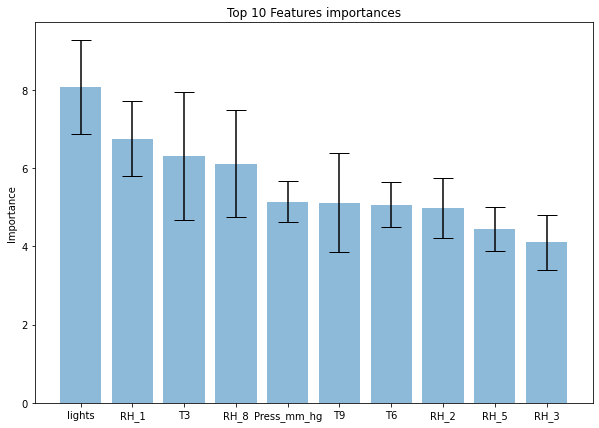

In [12]:
fig, ax = plt.subplots(figsize=(10,7))
ax.bar(positions, importance["mean"], yerr=importance["std"], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Importance')
ax.set_title('Top 10 Features importances')
ax.set_xticks(positions)
ax.set_xticklabels(importance.index.tolist())
plt.show()

**[?] В чём отличие между leaf-wise tree и depth-wise tree?**   
Отличие в порядке раскрытия веток дерева. В depth-wise деревьях порядок фиксированный, а в leaf-wise деревьях разбиение выбирается на основе его вклада в общие потери (не только потери по определенной ветви).

**[?] Сколько суммарно листьев у depth-wise tree глубины D?**    
У depth-wise tree глубины D суммарно **2^D** листьев

In [13]:
D = 4
N = 200 
L = 2**D    
print(f"Глубина одного дерева: {D}")
print(f"Количество деревьев: {N}")
print(f"Количество листьев в одном дереве: {L}")
print(f"Oбщее количество листьев: {L * N}")

Глубина одного дерева: 4
Количество деревьев: 200
Количество листьев в одном дереве: 16
Oбщее количество листьев: 3200


Для каждого фолда берем предсказания в виде индекса листа по каждому дереву и сразу переводим индексы листов в глобальные  

In [14]:
result_indexes = []
index_const = [i*L for i in range(N)]
for fold_number, [train_indx, test_indx] in enumerate(tscv.split(X)):
    target_indexes = np.concatenate((train_indx, test_indx), axis=0)
    target_data = X.iloc[target_indexes]
    relative_leaf_indexes = np.array(models[fold_number].calc_leaf_indexes(target_data))
    absolute_leafs_indexes = relative_leaf_indexes + index_const
    result_indexes.append(absolute_leafs_indexes)
    print(f"Fold №{fold_number + 1}")
    print(f"Relative indexes \nShape - {relative_leaf_indexes.shape} \n {relative_leaf_indexes[:10][:10]} \n")
    print(f"Absolute indexes \nShape - {absolute_leafs_indexes.shape} \n {absolute_leafs_indexes[:10][:10]} \n\n")

Fold №1
Relative indexes 
Shape - (10080, 200) 
 [[11 10  3 ...  0  7 14]
 [11 10  3 ...  8  7 14]
 [11 10  3 ...  0  7 14]
 ...
 [10 10  3 ...  0  6 14]
 [11 10  3 ...  8  7 14]
 [10 10  3 ...  0  6 14]] 

Absolute indexes 
Shape - (10080, 200) 
 [[  11   26   35 ... 3152 3175 3198]
 [  11   26   35 ... 3160 3175 3198]
 [  11   26   35 ... 3152 3175 3198]
 ...
 [  10   26   35 ... 3152 3174 3198]
 [  11   26   35 ... 3160 3175 3198]
 [  10   26   35 ... 3152 3174 3198]] 


Fold №2
Relative indexes 
Shape - (12096, 200) 
 [[11 12 14 ... 15  4 11]
 [11  4 14 ... 15  4 11]
 [11  4 14 ... 15  4 11]
 ...
 [10  4 14 ... 15  4 11]
 [11  6 14 ... 15  4 11]
 [10  6 14 ... 15  4 11]] 

Absolute indexes 
Shape - (12096, 200) 
 [[  11   28   46 ... 3167 3172 3195]
 [  11   20   46 ... 3167 3172 3195]
 [  11   20   46 ... 3167 3172 3195]
 ...
 [  10   20   46 ... 3167 3172 3195]
 [  11   22   46 ... 3167 3172 3195]
 [  10   22   46 ... 3167 3172 3195]] 


Fold №3
Relative indexes 
Shape - (14112, 

Кодируем глобальные индексы с помощью OHE

In [15]:
encoded_indexes = []
for leaf_indexes in result_indexes:
    leafs_df = pd.DataFrame(leaf_indexes)
    encoder = ColumnTransformer(
        [('OHE', OneHotEncoder(sparse=True), leafs_df.columns)],
    )
    encoded_data = encoder.fit_transform(leafs_df)
    encoded_indexes.append(encoded_data)

# D. Linear Regression

In [16]:
def plot_preds(preds, target, fold_number):
    x = range(100)
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(x, preds, label="Prediction",  linewidth=2)
    ax.plot(x, target, label="Real", linewidth=2)
    ax.set_xlabel("Date")
    ax.set_ylabel("Appliances")
    ax.set_title(f"Predictions for fold №{fold_number}")
    plt.legend()
    plt.show()

Функция для отрисовки весов первых десяти деревьев ансамбля (Note: для некоторых деревьев есть листы, в которые не попал ни один объект, соотвественно абсолютные номера таких листов пропущены. Также для кодирования использовался готовый кодировщик из sklearn, который не дает полного соотвествия  абсолютных нормеров листов с позициями единиц в закодированном представлении. Таким образом, формально,  первые 10 * L весов модели не соотвествуют в точности первым 10 деревьям и их листьям соответственно.)

In [17]:
def plot_weights(weights, fold_number):
    fig, ax = plt.subplots(figsize=(8,6))
    plt.scatter(range(len(weights)), weights, s=5, marker ="*")
    ax.set_xlabel("Tree absolute number")
    ax.set_ylabel("Weight")
    ax.set_title(f"First 10 trees weights for fold №{fold_number}")
    plt.show()

In [18]:
def plot_abs_weights(weights, fold_number):
    fig, ax = plt.subplots(figsize=(8,6))
    plt.scatter(range(len(weights)), abs(weights), s=5, marker ="*", color='red')
    ax.set_xlabel("Tree absolute number")
    ax.set_ylabel("Absolute weight")
    ax.set_title(f"First 10 trees weights for fold №{fold_number}")
    plt.show()

Функция для посторения регрессионных моделей по каждому фолду (Note: как и написано в задании предсказания бустинга были сделаны как для тренировочной, так и для валидационной части, но насколько мне известно строить метапризнаки на обучаюей выборке не совсем корректно, т.к. будет имет место переобучение, поскольку в метапризнаках будет содержаться информация о целевом векторе. Поэтому я обучала регерссионые модели только на валидационной выборке.)

In [19]:
def make_regression(encoded_indexes, l1_reg=False):
    models = []
    for fold_number, [train_indx, test_indx] in enumerate(tscv.split(X)):
        if (l1_reg):
            model = Lasso(alpha=0.666)
        else:
            model = LinearRegression()
            
        target_indexes = np.concatenate((train_indx, test_indx), axis=0)
        # Вариант для обучения регрессии на тренировочной и валидационной выборке
        # current_x, current_y = encoded_indexes[fold_number], Y.iloc[target_indexes]
        # Вариант для обучения регрессии только на валидационной выборке
        current_x, current_y = encoded_indexes[fold_number][-1008*2:], Y.iloc[test_indx]
        x_train, y_train = current_x[:-100], current_y[:-100]
        x_test, y_test = current_x[-100:], current_y[-100:]
        
        model.fit(x_train, y_train)
        plot_weights(model.coef_[:10*L], fold_number+1)
        plot_abs_weights(model.coef_[:10*L], fold_number+1)
        
        preds = model.predict(x_test)
        models.append(model)
        plot_preds(preds, y_test, fold_number+1)
        
        if (l1_reg):
            null_features_persentage = sum(model.coef_ == 0.0) / len(model.coef_) * 100
            print(f"Percentage of null features: {null_features_persentage}")
    return models

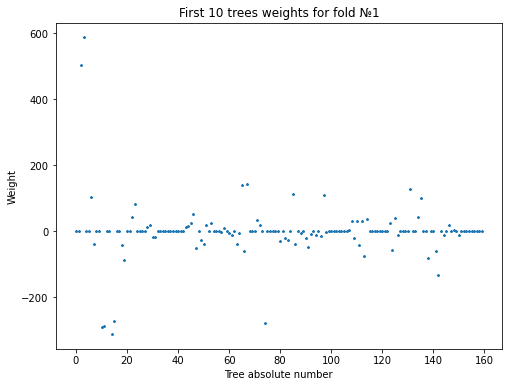

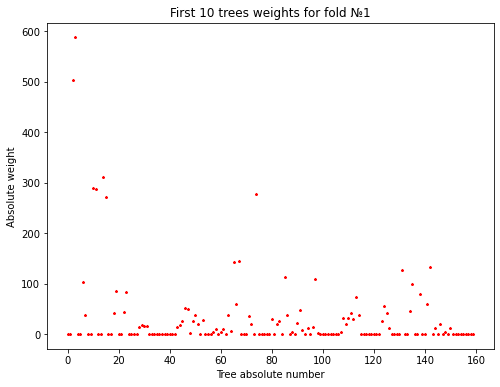

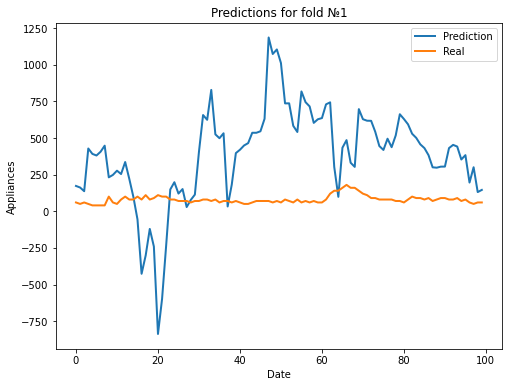

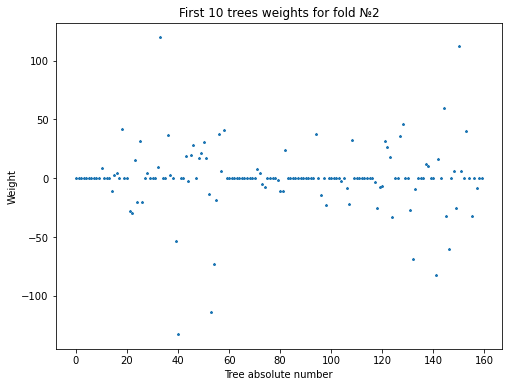

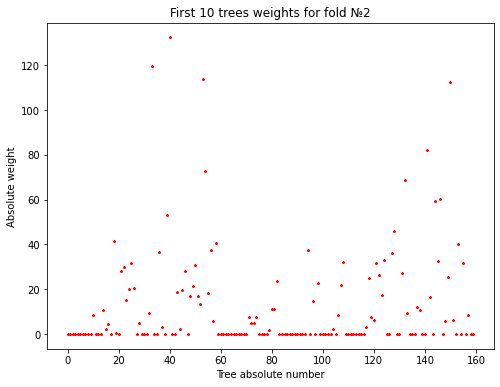

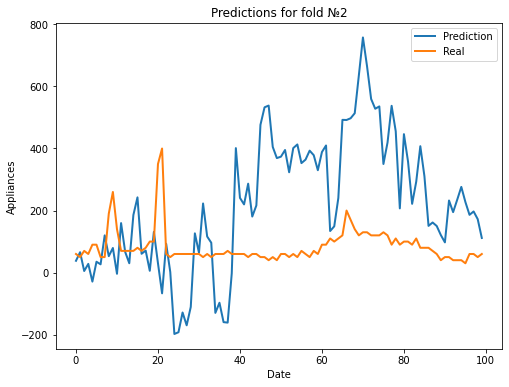

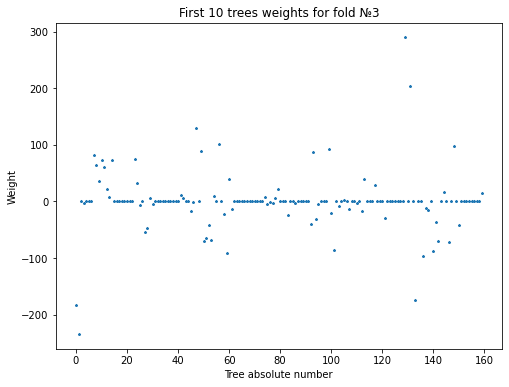

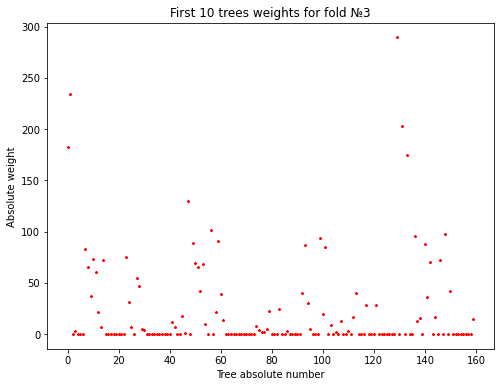

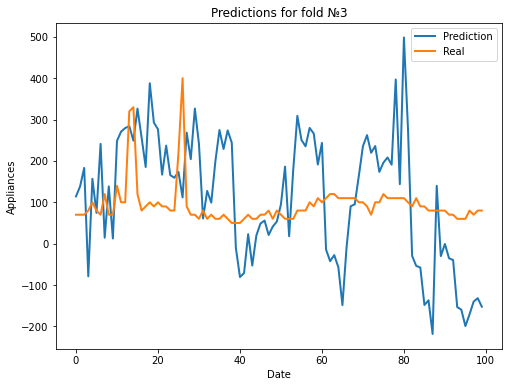

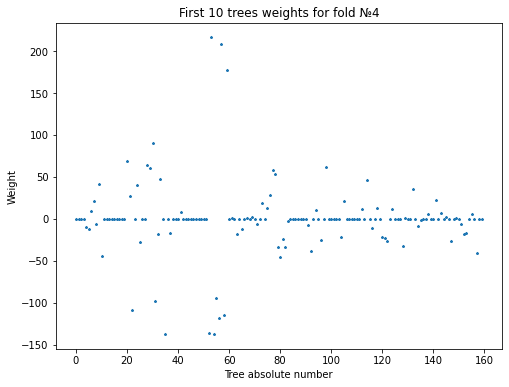

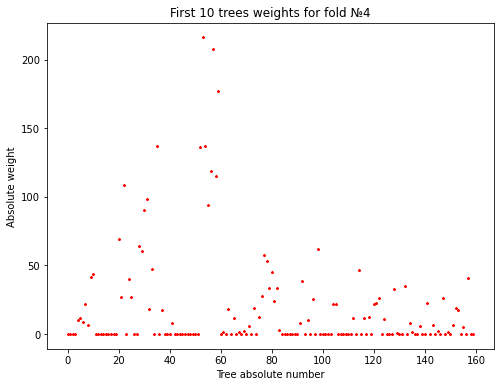

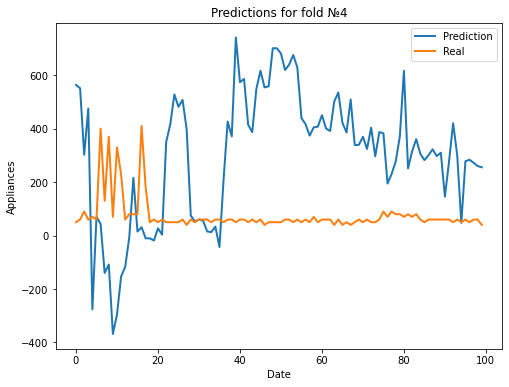

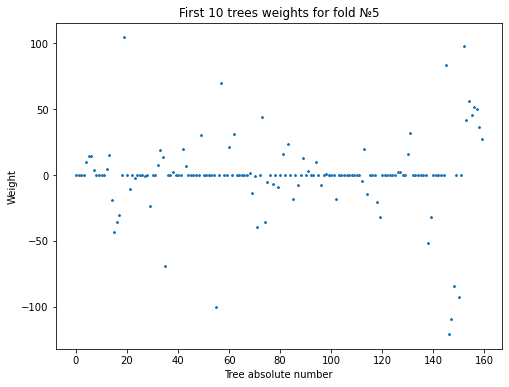

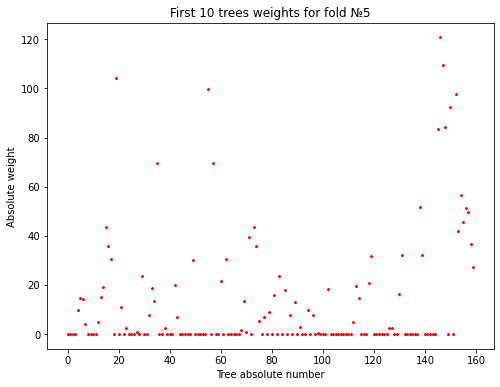

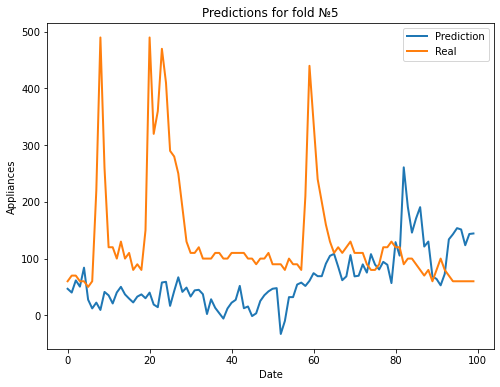

In [20]:
make_regression(encoded_indexes);

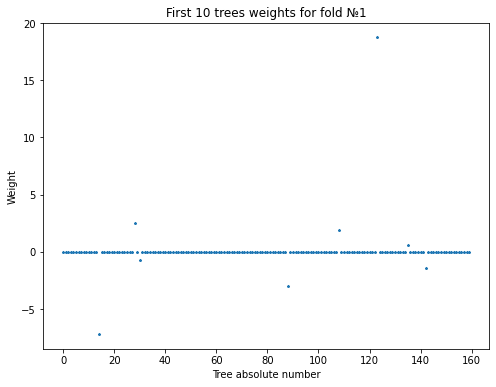

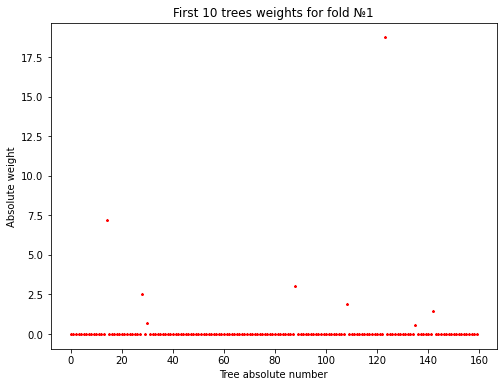

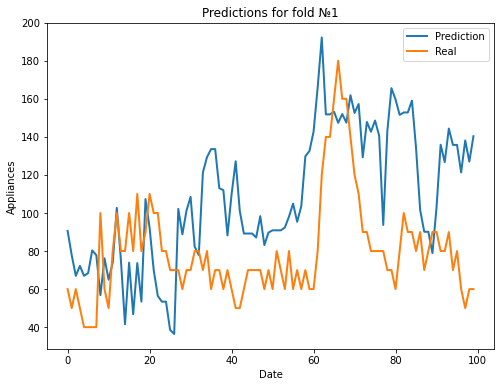

Percentage of null features: 94.5324881141046


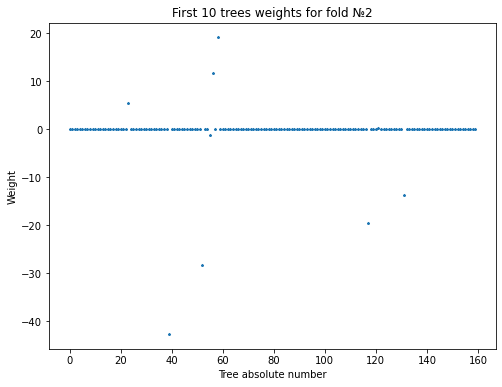

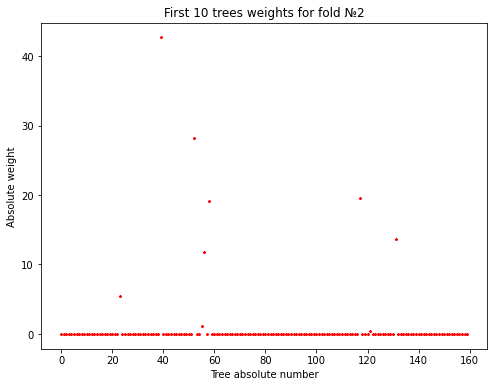

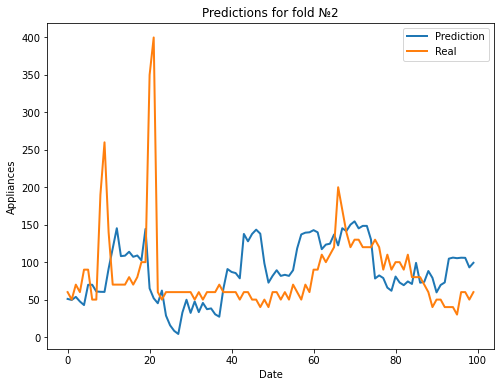

Percentage of null features: 95.84816132858838


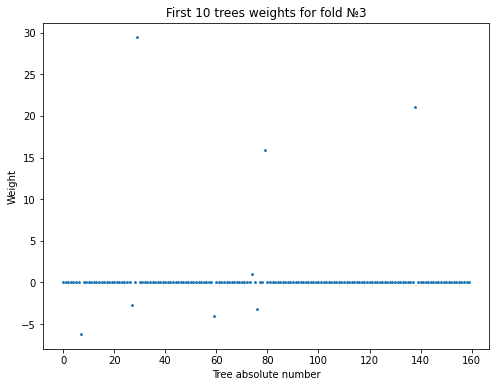

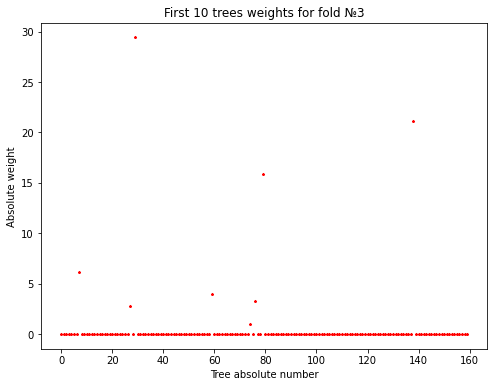

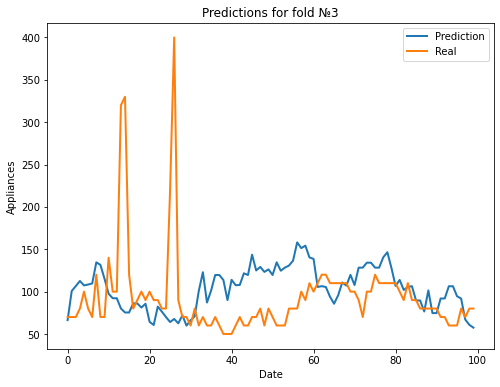

Percentage of null features: 95.5246913580247


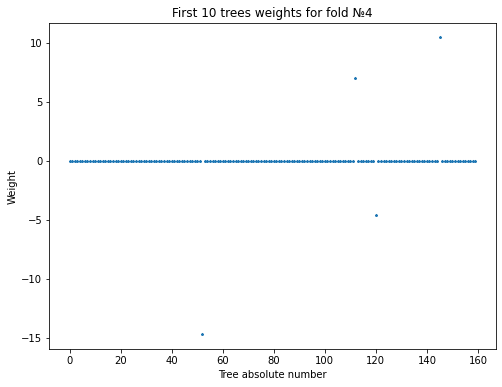

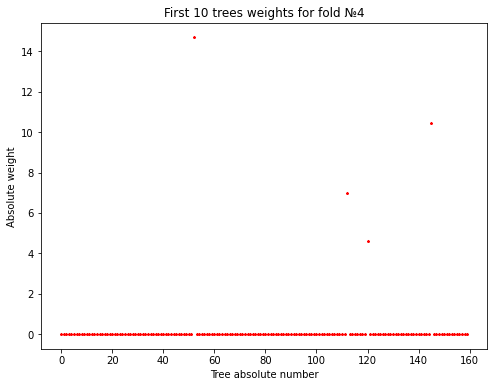

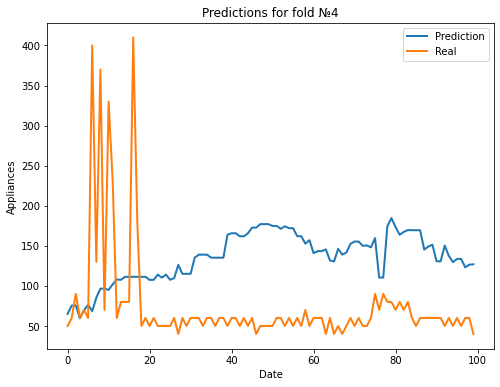

Percentage of null features: 95.96553074813944


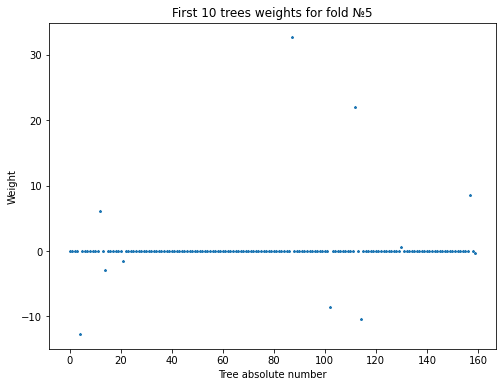

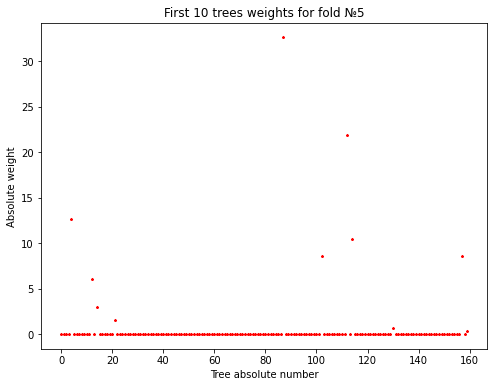

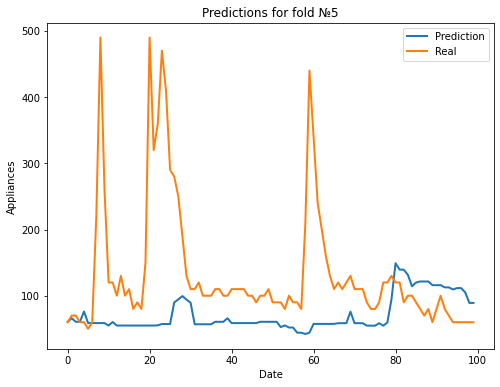

Percentage of null features: 96.83018867924528


In [21]:
linear_models = make_regression(encoded_indexes, True)

**[?] В чём разница между L1 и L2 регуляризацией?**  
    L1 регуляризация накладывает ограничение на сумму модулей весов модели, а L2 регуляризация на сумму квадратов весов модели. 

**[?] Почему L1 можно использовать для отбора признаков, а L2 нельзя?**   
    С геометрической точки зрения решение задачи сводится к поиску точки касании линии функции потерь и фигуры, ограничивающей область значений коэффициентов модели (для L1 регуляризации в двумерном случае это квадрат, а для L2 регуляризации круг). Из рисунка видно, что для квадрата существуют большие области (выделены зеленым), где точка касания выпадет на угол квадрата, и где одно из значений коэффициентов в точности равно нулю. В то же время касание со всеми точками круга равновероятно.   
    Т.к. при использовании L1 регуляризации больше шансов, что значения некоторых коэффициентов модели будут в точности раны нулю, ее можно использовать для отбора признаков.

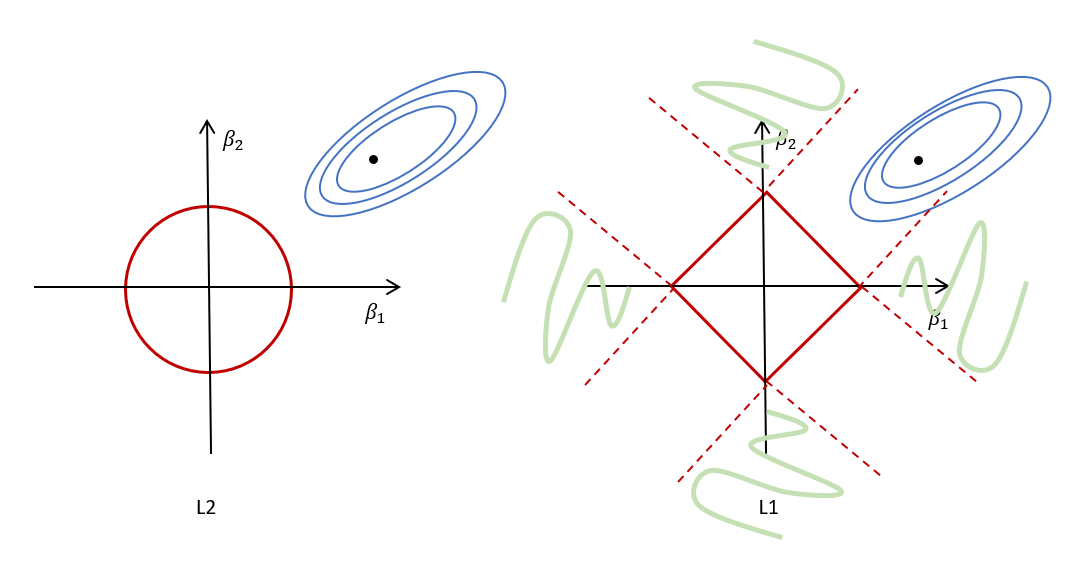

## Confidence Bound

**[?] Какие квантили отвечают за нижнюю и верхнюю границу 95%-го доверительного интервала?**  
LCB - квантиль порядка 0.025 и UCB - квантиль порядка 0.0975

Persentage for fold №1 - 60.0%
Persentage for fold №2 - 45.0%
Persentage for fold №3 - 54.0%
Persentage for fold №4 - 6.0%
Persentage for fold №5 - 11.0%


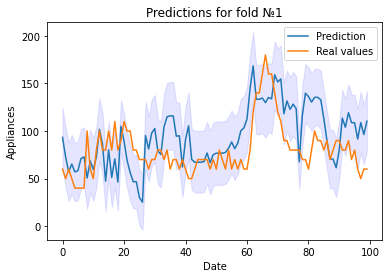

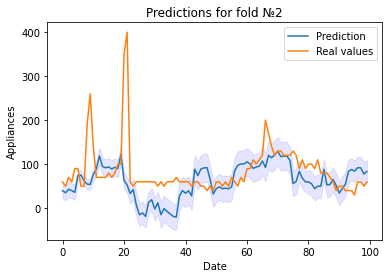

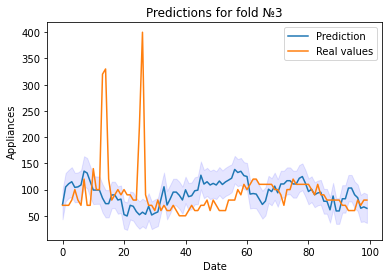

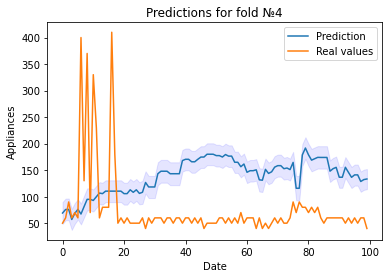

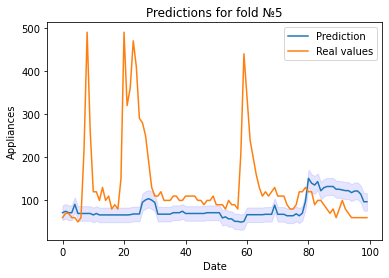

In [25]:
for fold_number, [train_indx, test_indx] in enumerate(tscv.split(X)):

    model = linear_models[fold_number]
    
    target_indexes = np.concatenate((train_indx, test_indx), axis=0)
    current_x, current_y = encoded_indexes[fold_number][-1008*2:], Y.iloc[test_indx]
    x_train, y_train = current_x[:-100], current_y[:-100]
    x_test, y_test = current_x[-100:], current_y[-100:]
    
    real_preds = model.predict(x_test)
    real_coefs = model.coef_
    
    global_preds = []
    for i in range(10000):
        noise = np.random.normal(1, 0.2, (len(model.coef_)))
        model.coef_ = real_coefs * noise
        preds = model.predict(x_test)
        global_preds.append(preds)

    LCBs = np.quantile(global_preds, q=0.025, axis=0)
    UCBs = np.quantile(global_preds, q=0.975, axis=0)

    x = range(100)
    fig, ax = plt.subplots()
    ax.plot(x, real_preds, label="Prediction")
    ax.plot(x, y_test, label="Real values")
    ax.fill_between(x, LCBs, UCBs, color='b', alpha=.1)
    ax.set_xlabel("Date")
    ax.set_ylabel("Appliances")
    ax.set_title(f"Predictions for fold №{fold_number + 1}")
    plt.legend()
    
    print(f"Persentage for fold №{fold_number + 1} - {sum(y_test.between(LCBs, UCBs)) / len(y_test) * 100}%")